In [107]:
! pip install pandas
! pip install pydicom
! pip install seaborn

import glob, pylab, pandas as pd
import pydicom, numpy as np
from torch.utils.data import DataLoader, TensorDataset
from skimage.transform import resize


import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

import torch
cuda = torch.cuda.is_available()

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

import torch.nn as nn
from torch.nn.functional import softplus
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, Dropout2d, MaxPool2d, BatchNorm1d, BatchNorm2d, ReLU, ELU
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax, dropout, dropout2d
import time


You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


GCP Credits Request Link - RSNA.txt  stage_1_sample_submission.csv
data.csv			     stage_1_test_images
note.txt			     stage_1_train_images
stage_1_detailed_class_info.csv      stage_1_train_labels.csv
0
100
200
300
400
500
600
700
800
900
1000
1023
Train data loaded
0
100
127
torch.Size([128, 1, 224, 224])
Test data loaded


(-0.5, 223.5, 223.5, -0.5)

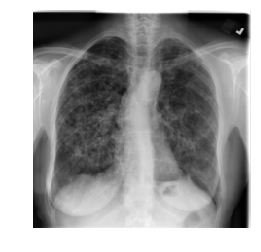

In [2]:
# Show files in data
!ls data

# display label format
df = pd.read_csv('data/stage_1_train_labels.csv')


# 
batch_size = 16
No_train_samples = 1024
No_test_samples = 128
No = 4
patientId = df['patientId'][No]
dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
#print(df.iloc[No])


#print(np.unique(df.Target))
#print(df['patientId'])

IMG_SIZE = 224
img_dimension = [IMG_SIZE,IMG_SIZE] # New size of xray images. 
unq, idx = np.unique(df['patientId'], return_index = True) # Get only unique entrances from the provided data (some patients occur multiple times)

# Reshape images and match to corresponding label in new dataframe
Target = []
Image = []
for i in range(0,No_train_samples):
    Target.append(df.Target[idx[i]]) # Get label  
    patientId = df['patientId'][idx[i]] # Get patient id from the idx 
    dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    dcm_data = pydicom.read_file(dcm_file) # Load the image 
    Image.append(resize(dcm_data.pixel_array, output_shape=img_dimension, mode='reflect', anti_aliasing=True)) # resize image
    if not i % 100:
        print(i)
print(i)

# Convert to Tensor
Target = torch.Tensor(Target)
Image = torch.Tensor(Image)
Image = Image.unsqueeze(1)

# Construct DataLoader
loader = TensorDataset(Image, Target)
train_loader = DataLoader(loader, batch_size=batch_size, shuffle = True)
print('Train data loaded')
        
Target = []
Image = []
for i in range(0,No_test_samples):
    Target.append(df.Target[idx[No_train_samples+i]]) # Get label  
    patientId = df['patientId'][idx[No_train_samples+i]] # Get patient id from the idx 
    dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    dcm_data = pydicom.read_file(dcm_file) # Load the image 
    Image.append(resize(dcm_data.pixel_array, output_shape=img_dimension, mode='reflect', anti_aliasing=True)) # resize image
    if not i % 100:
        print(i)
print(i)

# Convert to Tensor
Target = torch.Tensor(Target)
Image = torch.Tensor(Image)
Image = Image.unsqueeze(1)
print(Image.shape)

# Construct DataLoader
loader = TensorDataset(Image, Target)
test_loader = DataLoader(loader, batch_size=batch_size, shuffle = True)
print('Test data loaded')

# Show an example image
im = Image[0]
im = im.squeeze(0)
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [126]:
# define size variables
height = IMG_SIZE
width = IMG_SIZE
channels = 1
num_features = 224**2

# Regulization
L2_reg = 1e-6

# 1. Conv Layer
conv_out_channels_1 = 4
conv_kernel_1 = 5
conv_padding_1 = 2
conv_stride_1 = 1

# 1. MaxPool Layer
pool_kernel_1 = conv_kernel_1
pool_padding_1 = 2
pool_stride_1 = 2

# 2. Conv Layer
conv_out_channels_2 = 8
conv_kernel_2 = 5
conv_padding_2 = conv_padding_1
conv_stride_2 = 1

# 2. MaxPool Layer
pool_kernel_2 = 3
pool_padding_2 = 0
pool_stride_2 = 2


# Calculating the dimensions 
def compute_conv_dim(height, width, kernel_size, padding_size, stride_size):
    height_new = int((height - kernel_size + 2 * padding_size) / stride_size + 1)
    width_new =  int((width  - kernel_size + 2 * padding_size) / stride_size + 1)
    return [height_new, width_new]

def compute_final_dimension(height, width, last_num_channels):
    # First conv layer
    CNN_height, CNN_width = compute_conv_dim(height, width, 
                                             conv_kernel_1, conv_padding_1, conv_stride_1)
    # First maxpool layer
    CNN_height, CNN_width = compute_conv_dim(CNN_height, CNN_width, 
                                             pool_kernel_1, pool_padding_1, pool_stride_1)
    # Second conv layer
    CNN_height, CNN_width = compute_conv_dim(CNN_height, CNN_width,
                                             conv_kernel_2, conv_padding_2, conv_stride_2)
    # Second maxpool layer
    CNN_height, CNN_width = compute_conv_dim(CNN_height, CNN_width,
                                             pool_kernel_2, pool_padding_2, pool_stride_2)
    final_dim = CNN_height * CNN_width * last_num_channels
    return final_dim


######## Image has to be: (num, channels, height, width)!!!! #########
class CNN_VAE(nn.Module):
    def __init__(self, latent_features, num_samples):
        super(CNN_VAE, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples
        
        # Calculate final size of the CNN
        self.final_dim = compute_final_dimension(height,width,conv_out_channels_2)

        ## CNN encoder
        self.encoder = nn.Sequential(
            Conv2d(in_channels=channels,
                             out_channels=conv_out_channels_1,
                             kernel_size=conv_kernel_1,
                             stride=conv_stride_1,
                             padding=conv_padding_1),
            
            MaxPool2d(kernel_size=pool_kernel_1, 
                             stride=pool_stride_1,
                             padding=pool_padding_1),
            ReLU(),
            BatchNorm2d(conv_out_channels_1),
            Dropout2d(p=0.2),
            
            Conv2d(in_channels=conv_out_channels_1,
                             out_channels=conv_out_channels_2,
                             kernel_size=conv_kernel_2,
                             stride=conv_stride_2,
                             padding=conv_padding_2),
            
            MaxPool2d(kernel_size=pool_kernel_2,
                             stride=pool_stride_2,
                             padding=pool_padding_2),
            ReLU(),
            BatchNorm2d(conv_out_channels_2),
            Dropout2d(p=0.2)
        )
        
        self.CNN_to_latent = Linear(in_features=self.final_dim, out_features=self.latent_features*2)
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            Linear(in_features=self.latent_features, out_features=128),
            ELU(),
            BatchNorm1d(num_features=128, eps=1e-3),
            Linear(in_features=128, out_features=256),
            ELU(),
            BatchNorm1d(num_features=256),
            Linear(in_features=256, out_features=num_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        x = self.encoder(x)
        batch_size = x.size(0)
        x = x.view( batch_size, -1)
        x = self.CNN_to_latent(x)
        
        # Split encoder outputs into a mean and variance vector
        mu, log_var = torch.chunk(x, 2, dim=-1)
        
        # Make sure that the log variance is positive
        log_var = softplus(log_var)
        
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.num_samples, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        sigma = torch.exp(log_var/2)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        print(epsilon.shape)
        print(sigma.shape)
        print(mu.shape)
        z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)  
        print("z")
        print(z.shape)
        
        # Run through decoder
        z.view(0,-1)
        print("z")
        print(z.shape)
        x = self.decoder(z)
        
        # The original digits are on the scale [0, 1]
        x = torch.sigmoid(x)
        
        # Mean over samples
        x_hat = torch.mean(x, dim=1)
        
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs


latent_features = 4
# The number of samples used then initialising the VAE, 
# is number of samples drawn from the distribution
num_samples = 10

net = CNN_VAE(latent_features, num_samples)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)


CNN_VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2)
    (5): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2)
  )
  (CNN_to_latent): Linear(in_features=24200, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=256

In [101]:
from torch.nn.functional import binary_cross_entropy
from torch import optim

def ELBO_loss(y, t, mu, log_var):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()


# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

In [127]:
from torch.autograd import Variable

x, _ = next(iter(train_loader))
x = Variable(x)
if cuda:
    x = x.cuda()

outputs = net(x)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

print(torch.sum(torch.isnan(x)))
print(torch.sum(torch.isnan(x_hat)))
print(outputs["mu"])
print(outputs["log_var"])
print(net.CNN_to_latent.weight)

loss, kl = loss_function(x_hat, x, mu, log_var)

print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

torch.Size([16, 10, 4])
torch.Size([16, 4])
torch.Size([16, 4])
z
torch.Size([16, 10, 4])
z
torch.Size([16, 10, 4])


RuntimeError: running_mean should contain 10 elements not 256

Using device: cpu
z
torch.Size([16, 16, 4])


/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([16, 1, 224, 224])) that is different to the input size (torch.Size([16, 50176])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size([16, 16, 4])
z
torch.Size

RuntimeError: running_mean should contain 256 elements not 16

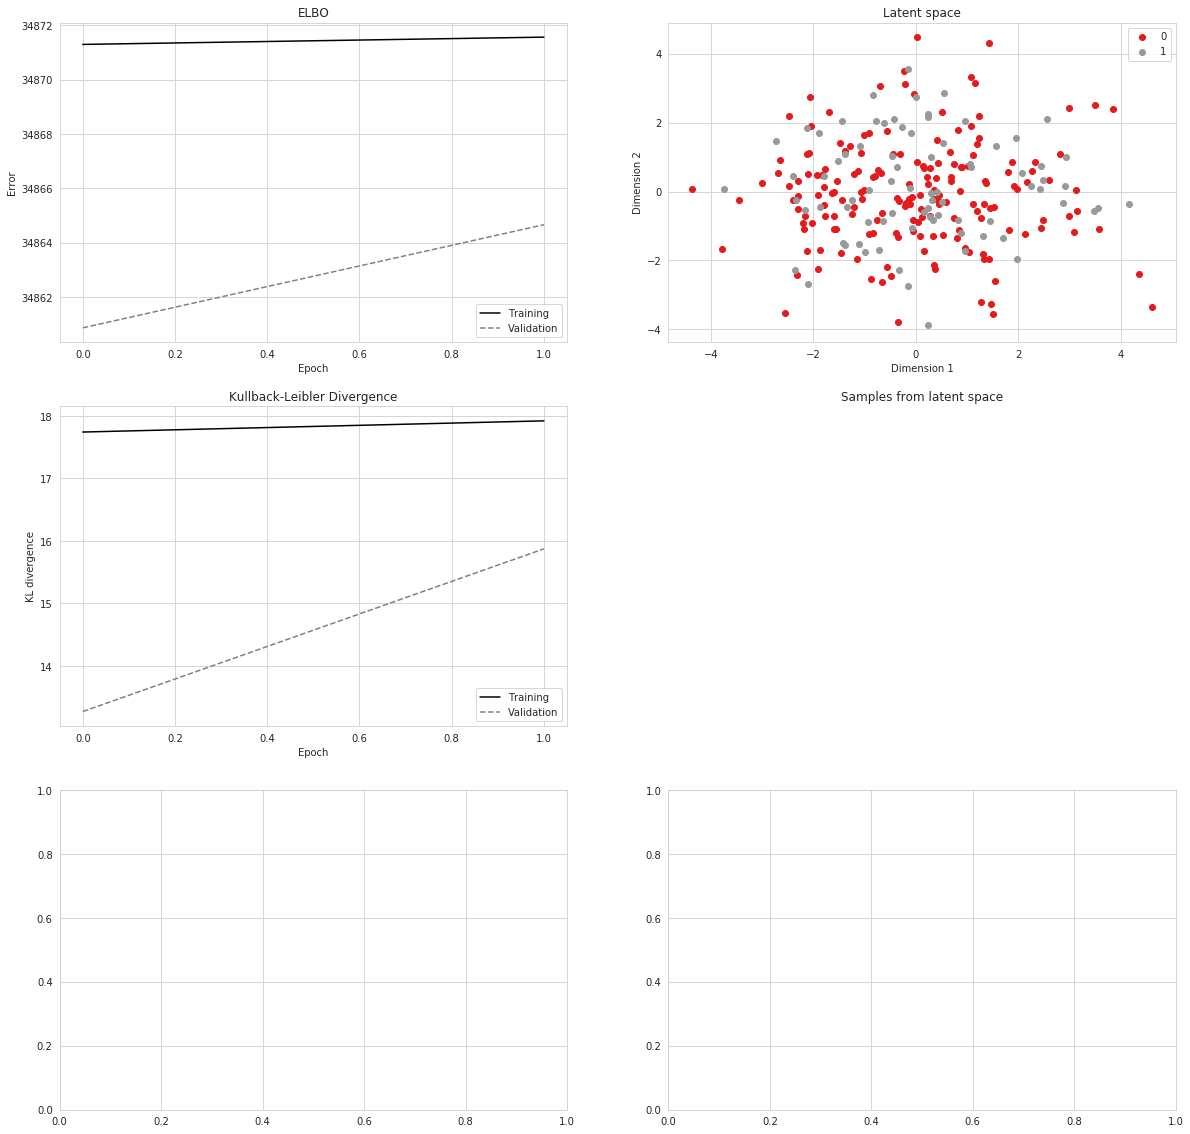

In [44]:
# Deleting variable Image and reload package Image
%reset_selective -f "^Image$"
from IPython.display import Image


import os
from sklearn.decomposition import PCA


num_epochs = No_train_samples // batch_size
tmp_img = "tmp_vae_out.png"
show_sampling_points = False
classes = [0,1]

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

for epoch in range(num_epochs):
    batch_loss, batch_kl = [], []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        x = Variable(x)
        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl = loss_function(x_hat, x, mu, log_var)
        
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        
        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())

    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = Variable(x)
        
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]
    
        elbo, kl = loss_function(x_hat, x, mu, log_var)
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
        
        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())
    
    if epoch == 0:
        continue
    
    # -- Plotting --
    f, axarr = plt.subplots(3, 2, figsize=(20, 20))

    # Loss
    ax = axarr[0, 0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])

    # Latent space
    ax = axarr[0, 1]

    ax.set_title('Latent space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    
    rows = 4
    columns = batch_size // rows
    
    span = np.linspace(-4, 4, rows)
    grid = np.dstack(np.meshgrid(span, span)).reshape(-1, 2)
    
    # If you want to use a dimensionality reduction method you can use
    # for example PCA by projecting on two principal dimensions

    z = PCA(n_components=2).fit_transform(z.reshape(-1,latent_features))
    z = z.reshape(batch_size,num_samples,2)
#     print(z.shape)
#     print(z.reshape(-1,latent_features).shape)
    colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    for c in classes:
        ax.scatter(*z[c == y.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)
        
    if show_sampling_points:
        ax.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")

    ax.legend()
    
    # KL / reconstruction
    ax = axarr[1, 0]
    
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(epoch+1), train_kl, color="black")
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    # Latent space samples
    ax = axarr[1, 1]
    ax.set_title('Samples from latent space')
    ax.axis('off')

    with torch.no_grad():
#         epsilon = torch.from_numpy(grid).float().to(device)
        epsilon = torch.randn(batch_size, latent_features).to(device)
        samples = torch.sigmoid(net.decoder(epsilon)).detach()

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = samples[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = samples[idx].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')

    # Inputs
    ax = axarr[2, 0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = x[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = x[idx].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[2, 1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = x_hat[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = x_hat[idx].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    #clear_output(wait=True)

    os.remove(tmp_img)

In [ ]:
print(torch.sum(torch.isnan(x)))